In [30]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [31]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [32]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [33]:
%matplotlib inline

In [34]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

#X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
#Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))
X_motion_CoM = X_motion_CoM_continuous
Y_motion_CoM = Y_motion_CoM_continuous
print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

no stored variable or alias X_motion_CoM_acceleration
no stored variable or alias Y_motion_CoM_acceleration
(4626, 61)
(4626, 3)


# Multivariate Linear Regression (CoM Prediction)

In [35]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [36]:
idx_fr_rl_swinging = np.where(X_motion_CoM[:, 55] == 1)[0]
X_motion_CoM_FR_RL = X_motion_CoM[idx_fr_rl_swinging]
Y_motion_CoM_FR_RL = Y_motion_CoM[idx_fr_rl_swinging]
print(X_motion_CoM_FR_RL.shape)
print(Y_motion_CoM_FR_RL.shape)

(2313, 61)
(2313, 3)


## Predict CoM (x) movement

In [37]:
X_motion_CoM_FR_RL[0, :]

array([ 1.00000001e-01,  0.00000000e+00,  0.00000000e+00,  2.37123758e-01,
        1.29492521e-01, -3.96473199e-01,  2.35636503e-01, -1.29854202e-01,
       -3.99378240e-01, -2.60216773e-01,  1.31444916e-01, -4.01650101e-01,
       -2.64598429e-01, -1.25929505e-01, -3.96399885e-01, -4.38515663e+00,
       -2.27757311e+00,  4.47428584e-01,  1.81728564e-02,  1.36686745e-03,
        5.76423630e-02, -4.24227454e-02, -4.24382426e-02, -2.46270886e-03,
        3.04491948e-02, -2.82363570e-03,  6.94693774e-02, -1.58019885e-02,
       -6.27183467e-02, -7.79861882e-02, -5.76661639e-02,  5.22246808e-02,
        7.75936916e-02,  5.87101281e-02, -1.36440182e+00, -4.05879021e-01,
        3.22345674e-01,  8.18385556e-02,  1.00004278e-01, -6.50247633e-01,
        7.48651862e-01, -1.93399582e-02, -5.69995358e-03,  1.74269461e-01,
        1.02392709e-01, -9.53243600e-02, -8.91508217e-02, -1.29498425e-03,
       -9.95984417e-04, -1.21180257e-02,  9.99925256e-01, -2.56564445e-03,
       -2.02320656e-03, -

In [38]:
Y_motion_CoM_FR_RL[0, :]

array([ 1.40502147e-02,  2.76613247e-05, -5.85405718e-03])

### Linear Regression

In [39]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, -3:], # Current motion command
               X_motion_CoM_FR_RL[:, 3:5], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 6:8], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 9:11], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 12:14])) # RR (x, y) position
               
# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_com_x = LinearRegression()

# Fit the model
model_fr_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9916088765218316
RMSE:  0.006997297982046028
The lowest error is:  2.4096255153427393e-05
The highest error is:  0.04716163220957792
The avg. error is:  0.004433657955360783


In [40]:
model_fr_com_x.coef_

array([[ 1.47444026e-01, -1.66533454e-16, -1.99435227e-03,
         3.34365611e-01,  2.40903683e-02,  8.57554091e-02,
         1.54634294e-02, -1.70482230e-01,  2.13591032e-01,
         4.24897970e-01, -3.83399408e-02]])

In [41]:
model_fr_com_x.intercept_

array([-0.06651264])

In [42]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0, 0.237936324231, 0.188065700274, 0.234281409653, -0.171743092874, -0.249921495098, 0.161507381121, -0.259071586366, -0.138188475913]])
output = input_ @ model_fr_com_x.coef_.T + model_fr_com_x.intercept_
print(output)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 11 is different from 14)

Text(0, 0.5, 'Predictions')

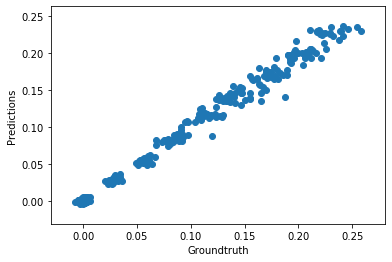

In [43]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [44]:
#%store model_fr_com_x

In [45]:
#for idx, prediction in enumerate(predictions):
#    print(f'Command: {X_test[idx, :3]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [46]:
# Save model
#joblib.dump(model_fr_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [47]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, -3:], # Current motion command
               X_motion_CoM_FR_RL[:, 3:5], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 6:8], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 9:11], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 12:14])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_com_y = LinearRegression()

# Fit the model
model_fr_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.18873960512402232
RMSE:  0.0026049531754680703
The lowest error is:  1.8315643000345327e-05
The highest error is:  0.017838593974682737
The avg. error is:  0.0018297455366746965


In [48]:
model_fr_com_y.coef_

array([[-2.66057058e-03,  7.97972799e-17, -8.37337404e-03,
        -1.18579867e-01,  3.39397225e-02, -1.30884565e-01,
        -2.66435291e-01,  1.64496144e-01, -1.93903347e-01,
         9.31595998e-02,  9.71268542e-02]])

In [49]:
model_fr_com_y.intercept_

array([0.12758223])

Text(0, 0.5, 'Predictions')

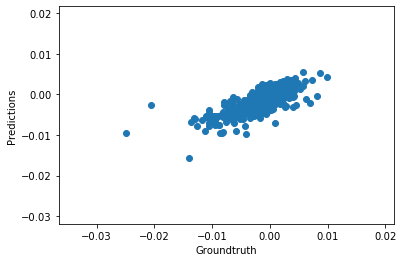

In [50]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [51]:
#%store model_fr_com_y

In [52]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [53]:
# Save model
#joblib.dump(model_fr_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_y.sav")

## Predict CoM -> Yaw

In [54]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, -3:], # Current motion command
               X_motion_CoM_FR_RL[:, 3:5], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 6:8], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 9:11], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 12:14])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_theta = LinearRegression()

# Fit the model
model_fl_com_theta.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_theta.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9682368320613751
RMSE:  0.011649141984834752
The lowest error is:  2.5798961987621993e-05
The highest error is:  0.11183571244556073
The avg. error is:  0.007051434060249695


In [55]:
model_fl_com_theta.coef_

array([[ 7.93315472e-03,  1.30798150e-15,  8.86832672e-02,
        -1.32287514e+00,  7.34045824e-01, -5.79498084e-01,
        -7.20251061e-01,  7.54919456e-01,  3.50483397e-01,
         1.30987148e+00, -1.02910443e+00]])

In [56]:
model_fl_com_theta.intercept_

array([0.63286575])

Text(0, 0.5, 'Predictions')

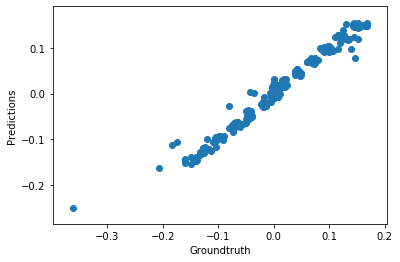

In [57]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")